In [1]:
from qiskit.circuit.library import MCXGate
from qiskit.quantum_info import Statevector
from qiskit.result.result import Result
from dbcquantum.circuit import AssertQuantumCircuit, AQCMeasure
from dbcquantum.utils import eq_state
from qiskit.opflow import Minus, Zero

In [2]:
# Problem

num_var = 4

# x1∧(￢x1∨x2)∧(￢x2∨x3∨x4)∧(￢x2∨￢x3)
cnf = [
    [1],
    [-1, 2],
    [-2, 3, 4],
    [-2, -3],
]

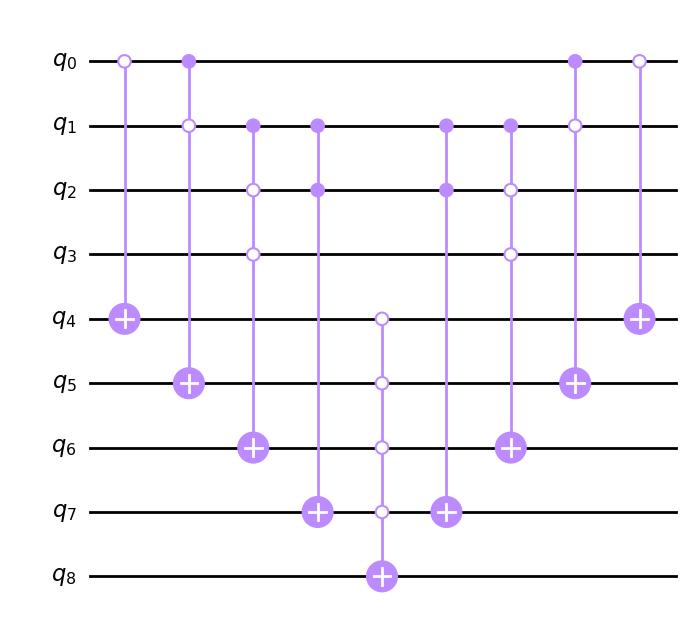

In [3]:
def make_oracle_3_SAT(num_var: int, cnf: list[list[int]]):
    n = num_var + len(cnf) + 1
    Uw = AssertQuantumCircuit(n)

    i = num_var

    encode = AssertQuantumCircuit(n - 1)
    for c in cnf:
        qubits = [abs(x) - 1 for x in c] + [i]
        ctrl_state = reversed(["0" if x > 0 else "1" for x in c])
        encode.append(
            MCXGate(num_ctrl_qubits=len(c), ctrl_state="".join(ctrl_state)), qubits
        )
        encode.add_pre_condition("encode: input must be |0>", lambda s: eq_state(s, Zero), focus_qubits=[i])
        i = i + 1

    Uw.append(encode, range(n-1))
    Uw.append(
        MCXGate(num_ctrl_qubits=len(cnf), ctrl_state="0" * len(cnf)), range(num_var, n)
    )
    Uw.append(encode.inverse(), range(n-1))

    return Uw


Uw = make_oracle_3_SAT(num_var=num_var, cnf=cnf)
Uw.remove_assertions().draw(output="mpl")

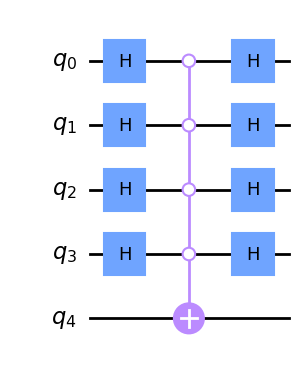

In [4]:
def make_Us(num_input: int) -> AssertQuantumCircuit:
    aqc = AssertQuantumCircuit(num_input + 1)
    for i in range(num_input):
        aqc.h(i)

    aqc.append(
        MCXGate(num_ctrl_qubits=num_input, ctrl_state="0" * num_input),
        list(range(num_input + 1)),
    )

    for i in range(num_input):
        aqc.h(i)

    return aqc


Us = make_Us(num_input=num_var)
Us.remove_assertions().draw(output="mpl")

In [5]:
def make_amplitude_amplification_circuit(
    Uw: AssertQuantumCircuit, Us: AssertQuantumCircuit
) -> AssertQuantumCircuit[int]:
    UwUs: AssertQuantumCircuit[int] = AssertQuantumCircuit(Uw.num_qubits)
    UwUs.append(Uw, range(UwUs.num_qubits))
    # UwUs.barrier(range(UwUs.num_qubits))
    UwUs.append(Us, list(range(num_var)) + [UwUs.num_qubits - 1])

    def condition(
        pre: Statevector,
        post: Statevector,
        answer: int,
    ) -> bool:
        pre_probs = pre.probabilities()
        post_probs = post.probabilities()

        ret = True
        for i in range(pre.dim):
            if i == answer:
                ret = (ret and pre_probs[i] < post_probs[i])
            else:
                ret = (ret and pre_probs[i] > post_probs[i])
        return ret

    UwUs.add_condition_use_param(
        "The answer must be amplified and others must be attenuated.",
        condition,
        focus_qubits=range(num_var),
    )
    return UwUs

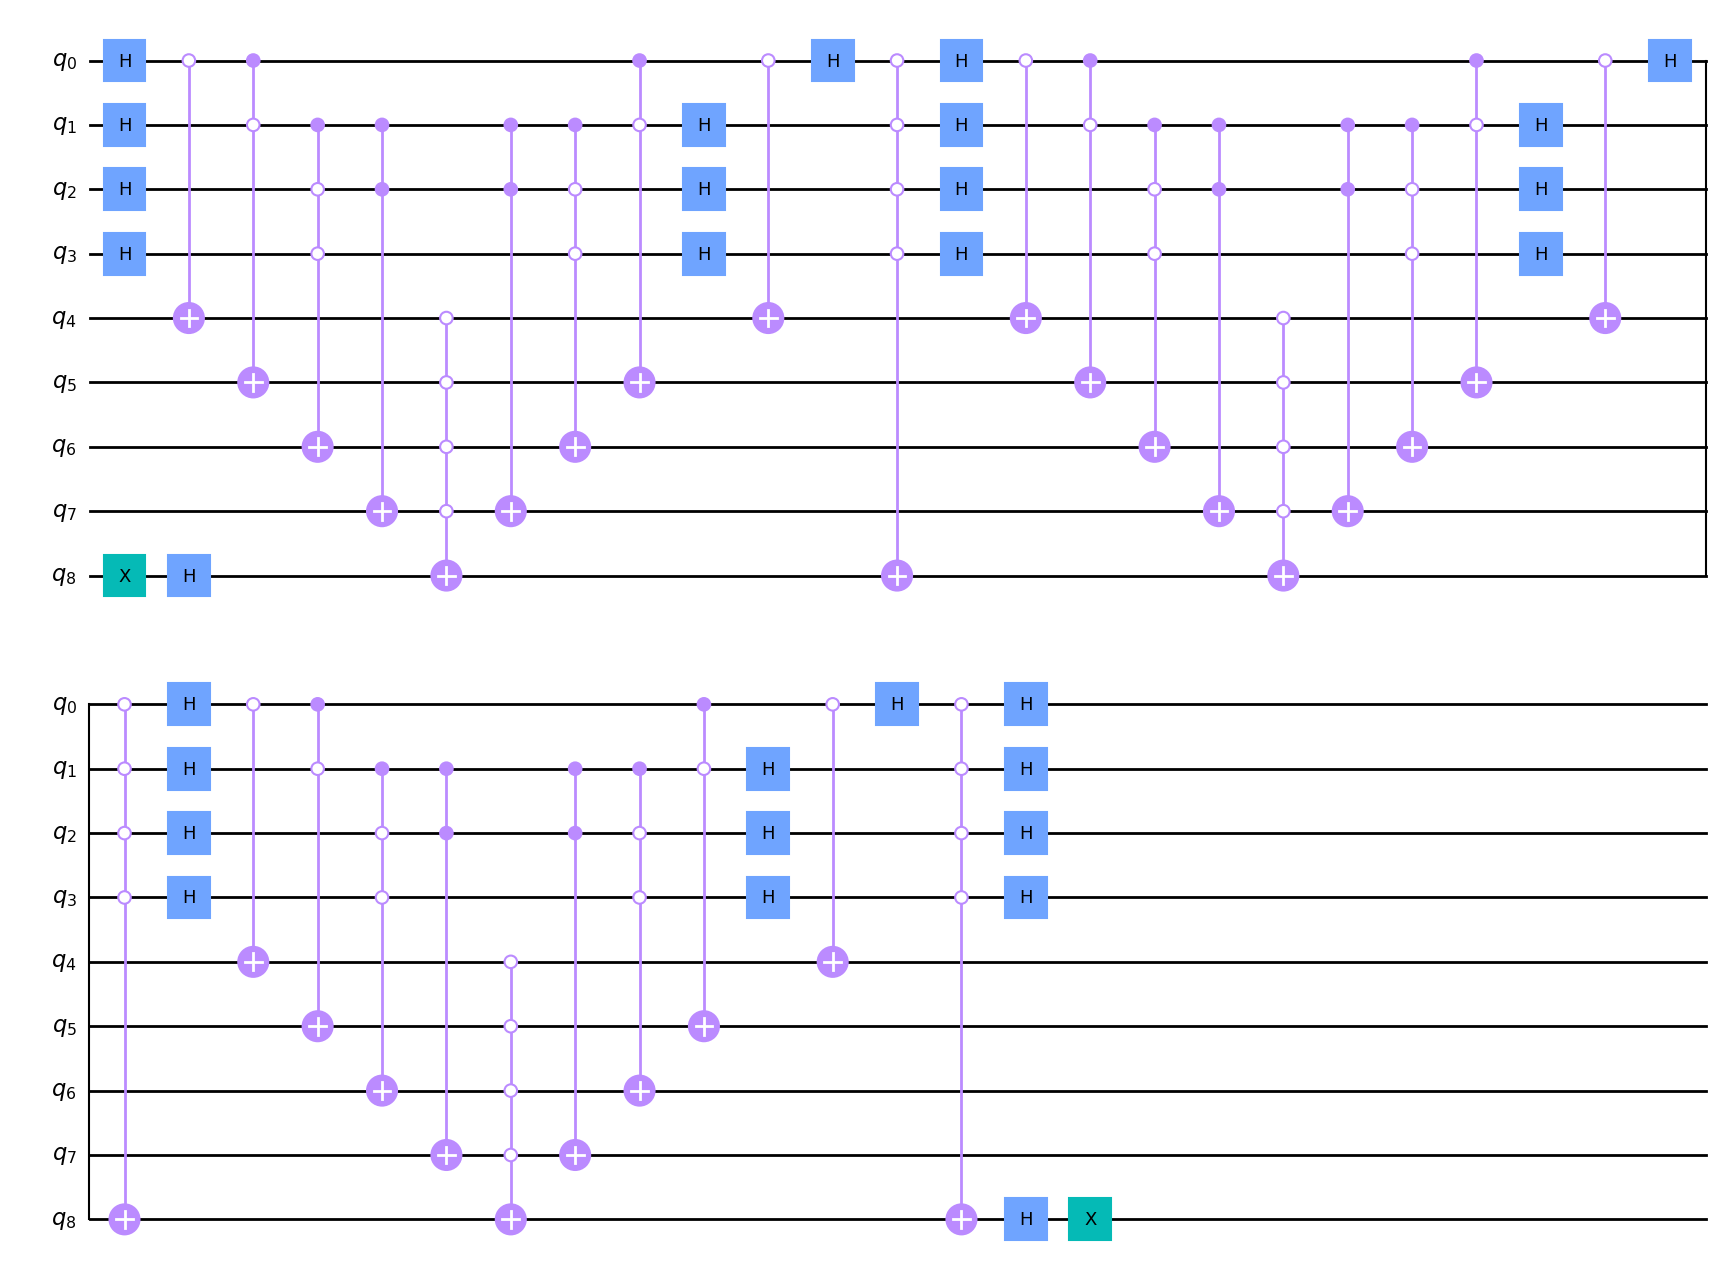

In [6]:
def make_grover_circuit(
    Uw: AssertQuantumCircuit, Us: AssertQuantumCircuit, repeat_num: int
) -> AssertQuantumCircuit[int]:
    grover_circuit: AssertQuantumCircuit[int] = AssertQuantumCircuit(Uw.num_qubits)

    for i in range(Us.num_qubits - 1):
        grover_circuit.h(i)

    make_minus = AssertQuantumCircuit(1)
    make_minus.x(0)
    make_minus.h(0)
    make_minus.add_pre_condition("zero", lambda s: eq_state(s, Zero))
    make_minus.add_post_condition("minus", lambda s: eq_state(s, Minus))

    grover_circuit.append(make_minus, [grover_circuit.num_qubits - 1])

    UwUs: AssertQuantumCircuit[int] = make_amplitude_amplification_circuit(Uw, Us)

    for i in range(repeat_num):
        # grover_circuit.barrier()
        grover_circuit.append(UwUs, range(grover_circuit.num_qubits))

    # grover_circuit.barrier()
    grover_circuit.append(make_minus.inverse(), [grover_circuit.num_qubits - 1])

    return grover_circuit


grover_circuit = make_grover_circuit(
    Uw=make_oracle_3_SAT(num_var=num_var, cnf=cnf),
    Us=make_Us(num_input=num_var),
    repeat_num=3,
)
grover_circuit.remove_assertions().draw(output="mpl")

In [7]:
def post_process(r: Result) -> str:
    return r.get_counts().most_frequent()  # type: ignore


answer = 0b1011

measured = AQCMeasure(grover_circuit, post_process, qubit=range(num_var))
measured.run(
    shots=100000, param=answer
)

'1011'

In [8]:
%%timeit -n 1 -r 5
measured.run(
    shots=1000, param=answer
)

382 ms ± 10.9 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [9]:
print("#qubits=")
print(measured.num_qubits)
print()
print("#gates=")
print(sum(measured.remove_assertions_to_circuit().count_ops().values()))

#qubits=
9

#gates=
66
